In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, fbeta_score, roc_curve, precision_recall_curve

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

plt.rcParams['figure.figsize'] = (10,10)

In [2]:
df = pd.read_json('ultimate_data_challenge.json')
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['target'] = df['last_trip_date'] > '2014-05-31'
df = df[['target','city','trips_in_first_30_days','signup_date','avg_rating_of_driver','avg_surge','last_trip_date','phone','surge_pct','ultimate_black_user','weekday_pct','avg_dist','avg_rating_by_driver']]
df['weekday_pct'] = df['weekday_pct']/100
df['avg_rating_of_driver'] = df['avg_rating_of_driver']/5
df['avg_rating_by_driver'] = df['avg_rating_by_driver']/5
df['surge_pct'] = df['surge_pct']/100

In [3]:
df.head()

,target,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,True,King's Landing,4,2014-01-25,0.94,1.10,2014-06-17,iPhone,0.154,True,0.462,3.67,1.00
1,False,Astapor,0,2014-01-29,1.00,1.00,2014-05-05,Android,0.000,False,0.500,8.26,1.00
2,False,Astapor,3,2014-01-06,0.86,1.00,2014-01-07,iPhone,0.000,False,1.000,0.77,1.00
3,True,King's Landing,9,2014-01-10,0.92,1.14,2014-06-29,iPhone,0.200,True,0.800,2.36,0.98
4,False,Winterfell,14,2014-01-27,0.88,1.19,2014-03-15,Android,0.118,False,0.824,3.13,0.98


In [4]:
df.isnull().sum()

target                       0
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [5]:
# replace missing avg ratings of/by driver with mean
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())

# drop entries with missing phone values
df = df.dropna(subset=['phone'])

In [6]:
df.isnull().sum()

target                    0
city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [7]:
df[df['target']].shape

(18671, 13)

Retained 18671 users.

## EDA

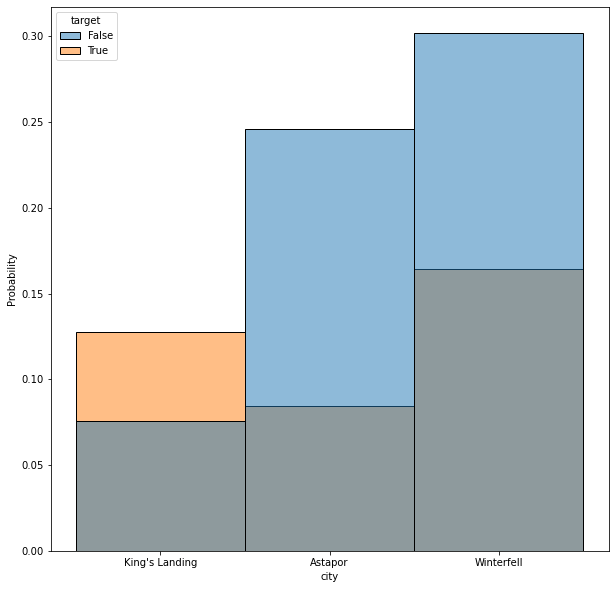

In [8]:
# histogram for city grouped by target
sns.histplot(data=df, x='city', hue='target', stat='probability')
plt.show()

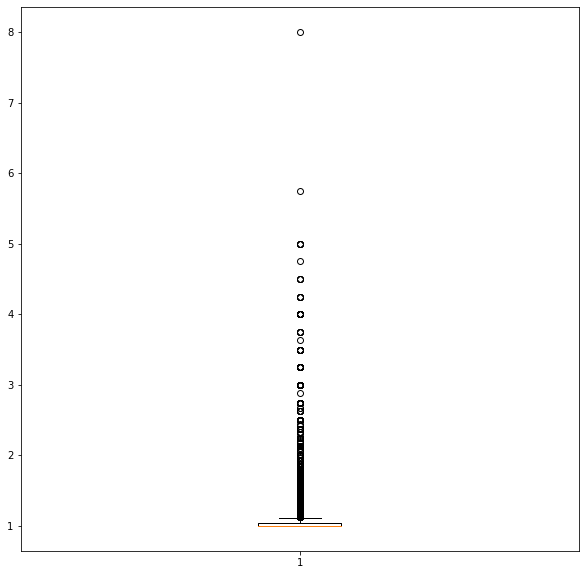

In [9]:
plt.boxplot(df['avg_surge'])
plt.show()

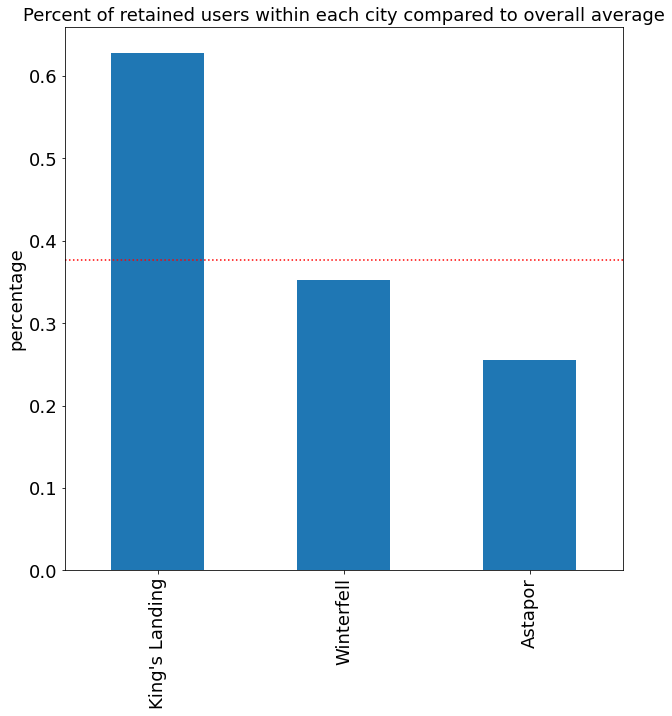

In [10]:
# percentage of retained users within each city compared to overall average

average_retained = df[df['target']].shape[0]/df.shape[0]

def percentage(city):
    t = df[(df['target']==True)&(df['city']==city)].shape[0]
    total = df[df['city']==city].shape[0]
    return t/total

city_rate = {city:percentage(city) for city in ["King's Landing", 'Astapor','Winterfell']}
city_rate = dict(sorted(city_rate.items(), key=lambda item: item[1], reverse=True))

pd.DataFrame(city_rate, index = [0]).transpose().plot.bar(legend=None, fontsize=18)
plt.hlines(y = average_retained, color='r', xmin=-.5,xmax=2.5, ls='dotted')
plt.ylabel('percentage', fontsize=18)
plt.title('Percent of retained users within each city compared to overall average', fontsize=18)
plt.show()

In [11]:
print(average_retained)

0.37640109668575117


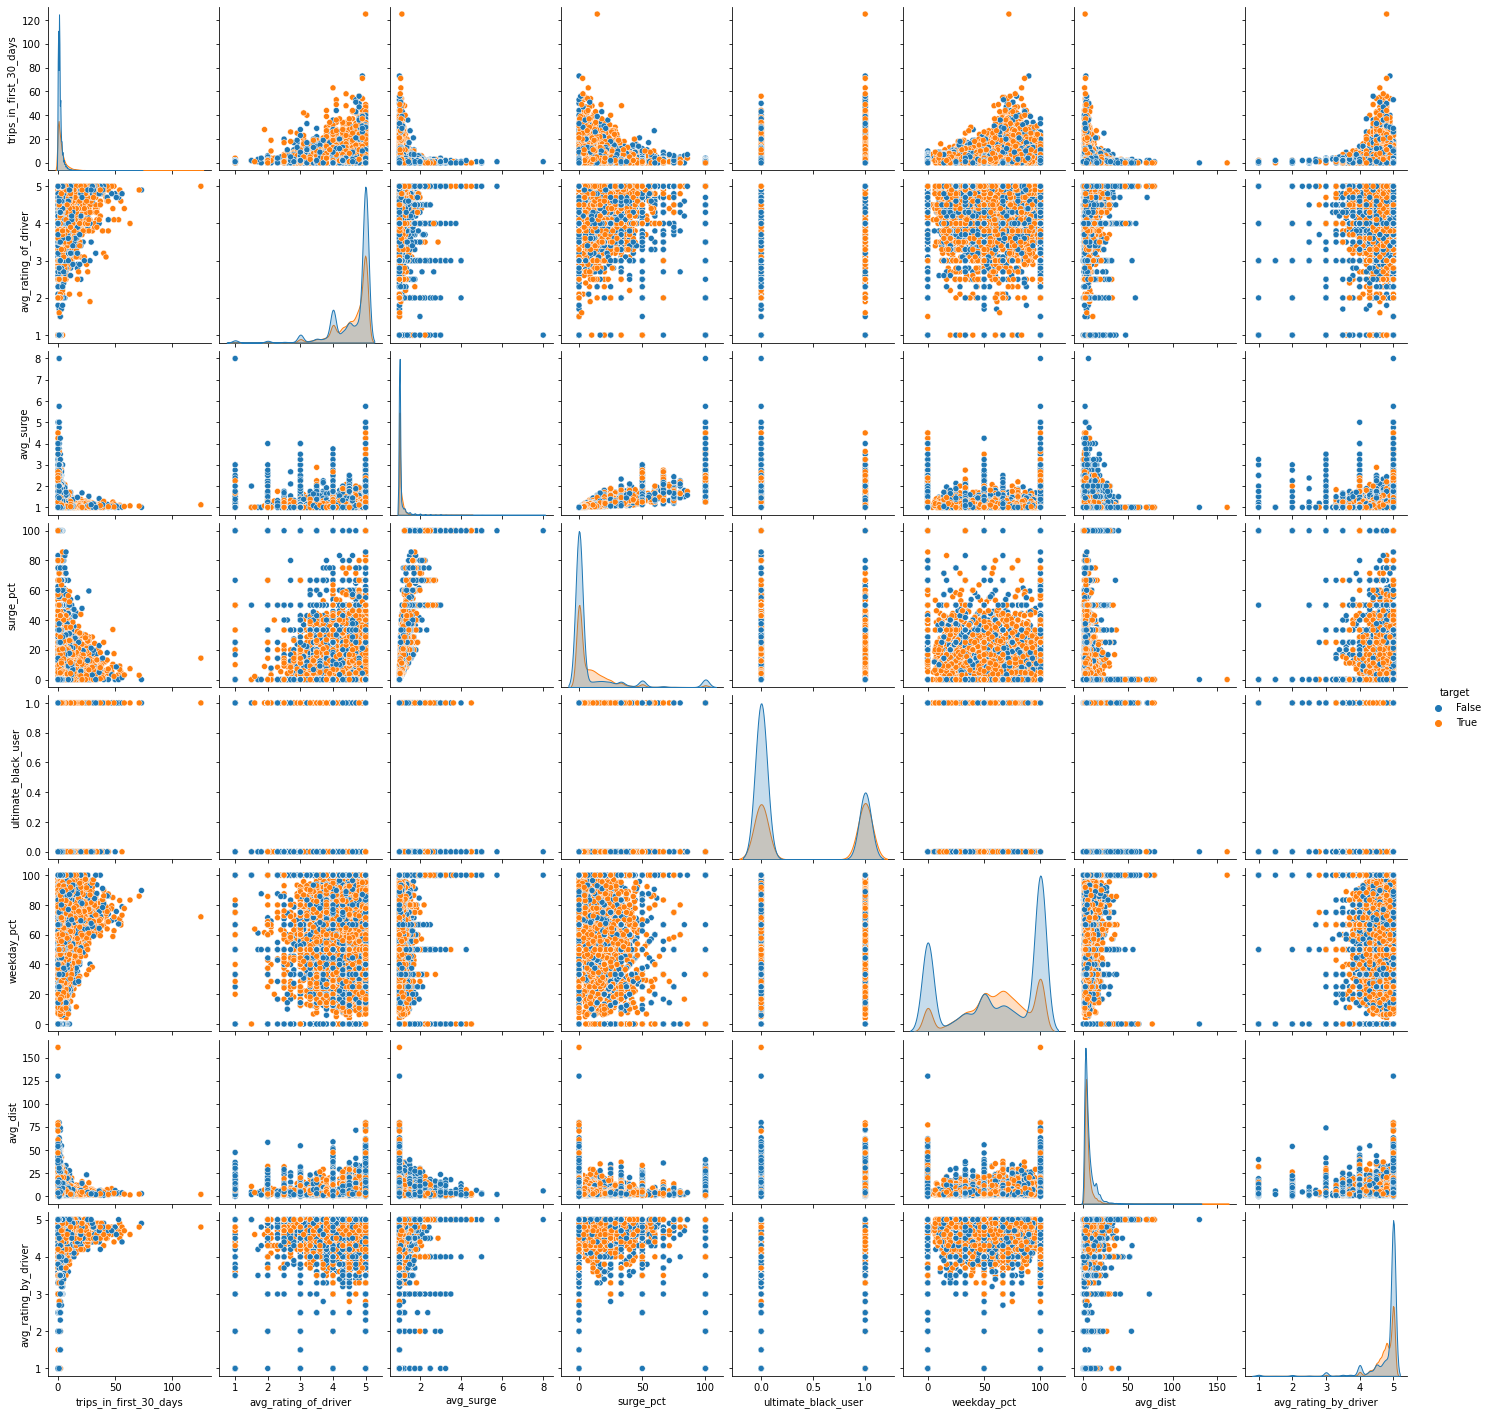

In [50]:
sns.pairplot(df, hue='target')
plt.show()

## Modeling

In [12]:
# obtain train mask

itrain, itest = train_test_split(range(df.shape[0]), stratify=df['target'], test_size=0.2, random_state=2)
mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itrain] = True

In [13]:
# scale trips_in_first_30_days and avg_dist

trips_scaler = MinMaxScaler()
dist_scaler = MinMaxScaler()
surge_scaler = RobustScaler()

trips_scaler.fit(np.array(df[mask]['trips_in_first_30_days']).reshape(-1,1))
dist_scaler.fit(np.array(df[mask]['avg_dist']).reshape(-1,1))
surge_scaler.fit(np.array(df[mask]['avg_surge']).reshape(-1,1))

df['trips_in_first_30_days'] = trips_scaler.transform(np.array(df['trips_in_first_30_days']).reshape(-1,1))
df['avg_dist'] = dist_scaler.transform(np.array(df['avg_dist']).reshape(-1,1))
df['avg_surge'] = surge_scaler.transform(np.array(df['avg_surge']).reshape(-1,1))

In [14]:
df = pd.get_dummies(df)

In [15]:
df.head()

,target,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,True,0.032,2014-01-25,0.94,2.0,2014-06-17,0.154,True,0.462,0.022801,1.00,0,1,0,0,1
1,False,0.000,2014-01-29,1.00,0.0,2014-05-05,0.000,False,0.500,0.051317,1.00,1,0,0,1,0
2,False,0.024,2014-01-06,0.86,0.0,2014-01-07,0.000,False,1.000,0.004784,1.00,1,0,0,0,1
3,True,0.072,2014-01-10,0.92,2.8,2014-06-29,0.200,True,0.800,0.014662,0.98,0,1,0,0,1
4,False,0.112,2014-01-27,0.88,3.8,2014-03-15,0.118,False,0.824,0.019446,0.98,0,0,1,1,0


In [16]:
X = df.drop(['target','signup_date','last_trip_date'], axis=1)
y = df['target']

X_train = X[mask]
X_test = X[~mask]

y_train = y[mask]
y_test = y[~mask]

In [19]:
# RandomizedSearchCV on random forest:

start = time.time()

steps = [('RF', RandomForestClassifier(random_state=2,n_jobs=3))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

criteria = ['gini','entropy']

depths = [int(n) for n in np.logspace(start=1, stop=2, num = 20)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,\
             'RF__criterion':criteria, 'RF__max_depth':depths, 'RF__max_features':num_features}

RF_pipe = Pipeline(steps)

RF_cv = RandomizedSearchCV(RF_pipe, param_distributions=RF_params, scoring='roc_auc', cv=3, random_state=2)

RF_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

RF_df = pd.DataFrame(RF_cv.cv_results_)
RF_df.to_csv('CV_results/RF_cv_results.csv')
RF_cv.best_score_

Time elapsed:  229.06479001045227


0.8486881909449654

In [20]:
RF_df.to_csv('CV_results/RF_cv_results.csv')
RF_cv.best_score_

0.8486881909449654

In [21]:
pred = RF_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test,pred))

0.7607732109995482


In [22]:
# GridSearchCV LogisticRegression 


start = time.time()

steps = [('LogReg', LogisticRegression())]

penalties = ['l1', 'l2', 'elasticnet', 'none']

duals = [True, False]

tols = [0.0001,0.001,0.01,0.1]

Cs = [0.01,0.1,1,2]

LogReg_params = {'LogReg__penalty':penalties, 'LogReg__dual':duals, 'LogReg__tol':tols, 'LogReg__C':Cs}

LogReg_pipe = Pipeline(steps)

LogReg_cv = GridSearchCV(LogReg_pipe, param_grid=LogReg_params, scoring='roc_auc', cv=3)

LogReg_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

LogReg_df = pd.DataFrame(LogReg_cv.cv_results_)
LogReg_df.to_csv('CV_results/LogReg_cv_results.csv')
LogReg_cv.best_score_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

Time elapsed:  39.896692991256714


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7598658816316034

In [23]:
pred = LogReg_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test,pred))

0.672547744034371


In [24]:
# RandomizedSearchCV on GradientBoostingClassifier:

start = time.time()

steps = [('gbc', GradientBoostingClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

depths = [3,7,15]

lr = [0.01, 0.1, 1]

gbc_params = {'gbc__n_estimators': n_est, 'gbc__learning_rate':lr, 'gbc__max_depth':depths}

gbc_pipe = Pipeline(steps)

gbc_cv = RandomizedSearchCV(gbc_pipe, param_distributions=gbc_params, cv=5, scoring='roc_auc', random_state=2)

gbc_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)


gbc_df = pd.DataFrame(gbc_cv.cv_results_)
gbc_df.to_csv('gbc_cv_results.csv')
gbc_cv.best_score_

Time elapsed:  2184.205845117569


0.8530644479087892

In [25]:
pred = gbc_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test,pred))

0.762486247015335


In [26]:
# RandomizedSearchCV on AdaBoostClassifier:

start = time.time()

steps = [('ada', AdaBoostClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3.5, num=30)]



lr = [0.01, 0.1, 1]

ada_params = {'ada__n_estimators': n_est, 'ada__learning_rate':lr}

ada_pipe = Pipeline(steps)

ada_cv = RandomizedSearchCV(ada_pipe, param_distributions=ada_params, cv=5, scoring='roc_auc', random_state=2)

ada_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)


ada_df = pd.DataFrame(ada_cv.cv_results_)
ada_df.to_csv('ada_cv_results.csv')
ada_cv.best_score_

Time elapsed:  803.407487154007


0.8474908268401972

In [27]:
pred = ada_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test,pred))

0.7567029811544829


## Threshold tuning

In [28]:
def y_crisp(probs, threshold):
    return (probs >= threshold).astype('int')

In [29]:
def fbeta(pre, rec, beta=1):
    return (1+beta**2)*(pre*rec)/((beta**2)*pre + rec)

In [30]:
def results(clf):
    start = time.time()
    print('Threshold analysis for ', clf.__class__.__name__)
    yproba = clf.predict_proba(X_test)[:,1]
    
    # plot F scores against thresholds for beta = 0.5, 1, 2
    
    thresh = np.arange(0,1,0.001)
    extraticks = []
    for beta, color, color_plot in zip([0.5, 1, 2],['black','blue','red'], ['grey','green','pink']):
        scores = np.array([fbeta_score(y_test, y_crisp(yproba, t), beta=beta) for t in thresh])
        ix = np.argmax(scores)
        best_thresh = thresh[ix]
        print('Best threshold for F_%s: %s'%(beta,best_thresh))
        plt.plot(thresh,scores, c = color_plot, label='F%s scores'%beta)
        plt.axvline(x=best_thresh, label='Best threshold for F_%s'%(beta), c=color)
        
        
        
        extraticks.append(best_thresh)
    
    plt.title('%s F-scores'%(clf.__class__.__name__), fontsize=18)
    plt.legend(loc='upper right', fontsize=18)
    plt.xlabel('thresholds', fontsize=18)
    plt.ylabel('F scores', fontsize=18)
#     plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1] + extraticks, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
#     plt.savefig('Report/%s_F-scores.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    # plot thresholds on precision-recall curve
    
    precision, recall, thresholds = precision_recall_curve(y_test, yproba)
    # convert to f score

    fhalfscore = fbeta(precision,recall,beta=0.5)
    f1score = fbeta(precision,recall)
    f2score = fbeta(precision,recall,beta=2)

    #fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ixhalf = np.nanargmax(fhalfscore)
    ix1 = np.nanargmax(f1score)
    ix2 = np.nanargmax(f2score)
    print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
    print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
    print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

    # plot the precision-recall curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='model')
    plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
    plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
    plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
    # axis labels
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall curve for %s'%(clf.__class__.__name__), fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    # show the plot
#     plt.savefig('Report/%s_precision_recall.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    # plot best gmean on ROC curve
    
    fpr, tpr, thresholds_roc = roc_curve(y_test, yproba)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_roc[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='%s'%(clf.__class__.__name__))
    plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best', markersize=10)
    # axis labels
    plt.title('best G-mean for %s'%(clf.__class__.__name__), fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # show the plot
#     plt.savefig('Report/%s_ROC_curve.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    print('ROC AUC score: ', roc_auc_score(y_test,yproba))
    
    # print out confusion matrices and classification reports
    
    good_thresholds = zip(['F_0.5', 'F_1', 'F_2', 'Gmeans'],[thresholds[ixhalf],thresholds[ix1],thresholds[ix2], thresholds_roc[ix]])

    for name, t in good_thresholds:
        y_pred = y_crisp(yproba,t)
        print('Threshold for ', name,': ', t)
        print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
        print('Classification report:\n', classification_report(y_test, y_pred))
    end = time.time()
    print('Time elapsed: ', end-start)

In [31]:
RF_cv.best_params_

{'RF__n_estimators': 1000,
 'RF__max_features': 'auto',
 'RF__max_depth': 10,
 'RF__criterion': 'entropy'}

In [32]:
gbc_cv.best_params_

{'gbc__n_estimators': 379, 'gbc__max_depth': 7, 'gbc__learning_rate': 0.01}

In [33]:
ada_cv.best_params_

{'ada__n_estimators': 434, 'ada__learning_rate': 1}

In [34]:
models = {'RF':RandomForestClassifier(n_estimators=1000,max_features='auto',max_depth=10,criterion='entropy',random_state=2),
          'GBC':GradientBoostingClassifier(n_estimators=379,max_depth=7,learning_rate=0.01, random_state=2), 
          'ADA':AdaBoostClassifier(n_estimators=434,learning_rate=1,random_state=2)}
          
for clf in list(models.values()):
    clf.fit(X_train,y_train)
        



Threshold analysis for  RandomForestClassifier
Best threshold for F_0.5: 0.552
Best threshold for F_1: 0.40900000000000003
Best threshold for F_2: 0.169


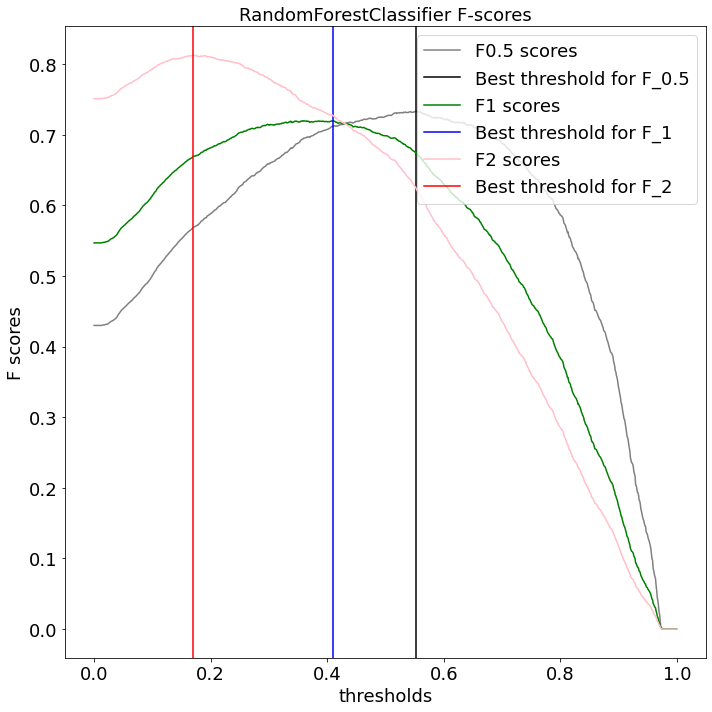

Best Threshold for F_0.5: 0.552079, F_0.5-Score=0.733
Best Threshold for F_1: 0.409161, F_1-Score=0.720
Best Threshold for F_2: 0.169677, F_2-Score=0.813


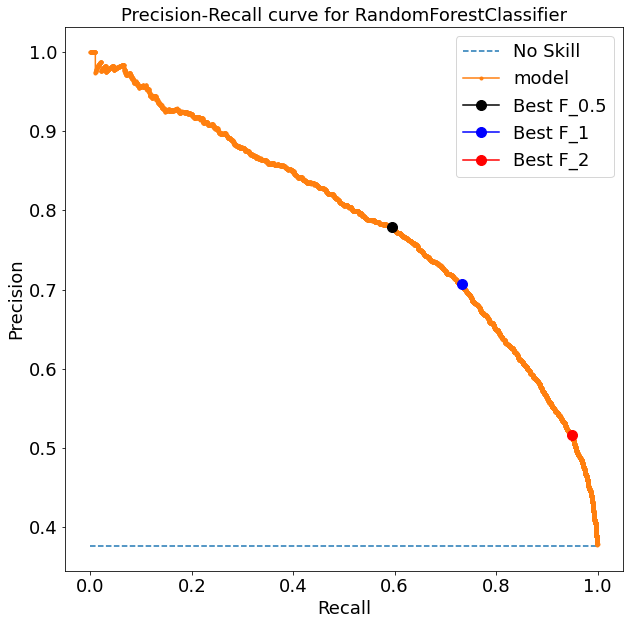

Best Threshold=0.409161, G-Mean=0.774


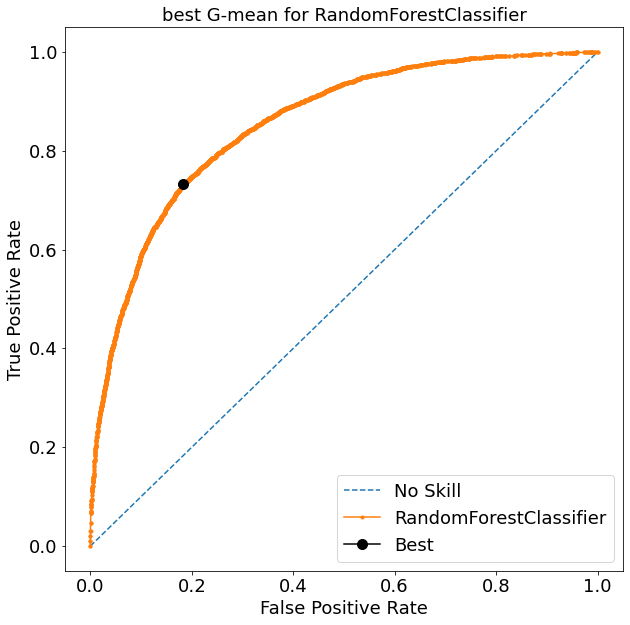

ROC AUC score:  0.854359842228409
Threshold for  F_0.5 :  0.5520785693671584
Confusion matrix: 
 [[5554  633]
 [1510 2224]]
Classification report:
               precision    recall  f1-score   support

       False       0.79      0.90      0.84      6187
        True       0.78      0.60      0.67      3734

    accuracy                           0.78      9921
   macro avg       0.78      0.75      0.76      9921
weighted avg       0.78      0.78      0.78      9921

Threshold for  F_1 :  0.4091613926656157
Confusion matrix: 
 [[5054 1133]
 [ 996 2738]]
Classification report:
               precision    recall  f1-score   support

       False       0.84      0.82      0.83      6187
        True       0.71      0.73      0.72      3734

    accuracy                           0.79      9921
   macro avg       0.77      0.78      0.77      9921
weighted avg       0.79      0.79      0.79      9921

Threshold for  F_2 :  0.16967725817233706
Confusion matrix: 
 [[2876 3311]
 [ 190 3544

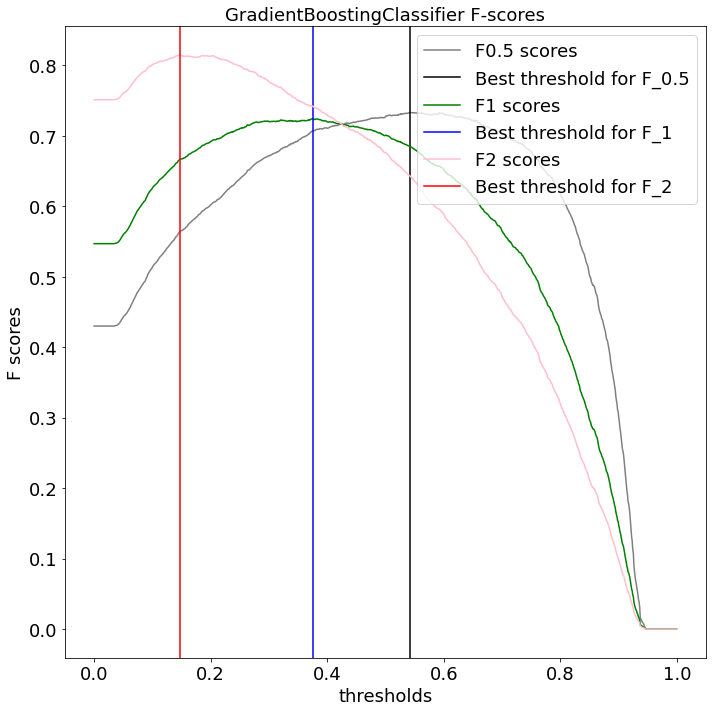

Best Threshold for F_0.5: 0.541677, F_0.5-Score=0.733
Best Threshold for F_1: 0.375154, F_1-Score=0.724
Best Threshold for F_2: 0.145903, F_2-Score=0.815


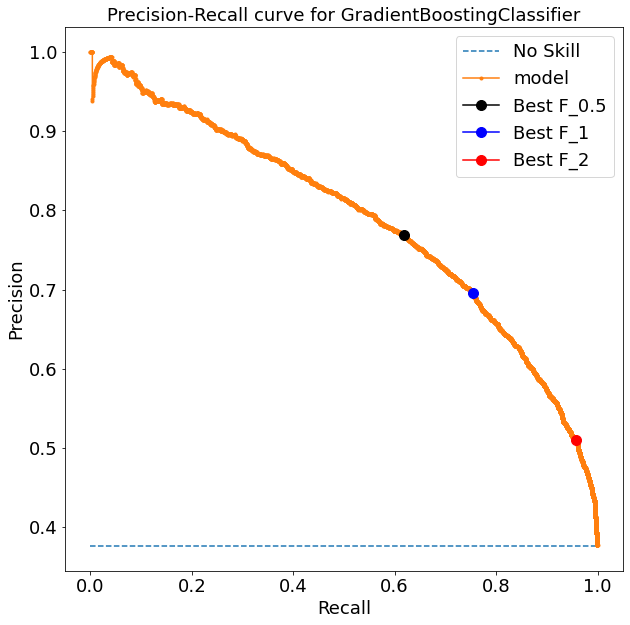

Best Threshold=0.375154, G-Mean=0.778


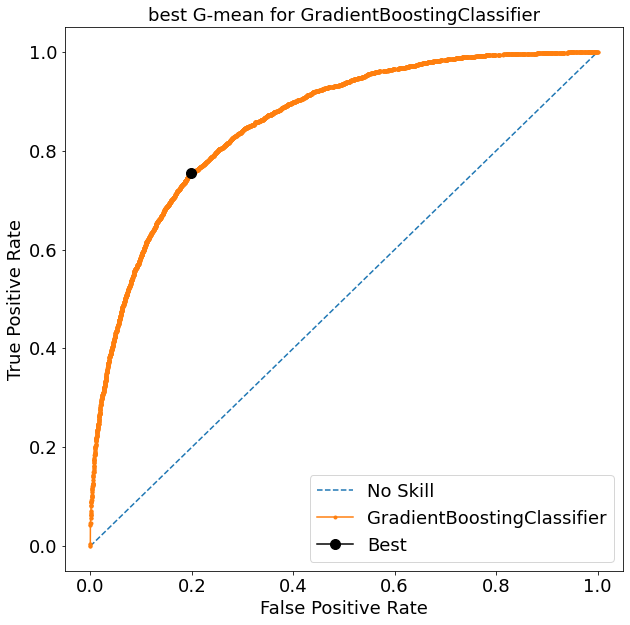

ROC AUC score:  0.8582382509969372
Threshold for  F_0.5 :  0.5416773104341511
Confusion matrix: 
 [[5495  692]
 [1427 2307]]
Classification report:
               precision    recall  f1-score   support

       False       0.79      0.89      0.84      6187
        True       0.77      0.62      0.69      3734

    accuracy                           0.79      9921
   macro avg       0.78      0.75      0.76      9921
weighted avg       0.78      0.79      0.78      9921

Threshold for  F_1 :  0.37515411788319114
Confusion matrix: 
 [[4957 1230]
 [ 916 2818]]
Classification report:
               precision    recall  f1-score   support

       False       0.84      0.80      0.82      6187
        True       0.70      0.75      0.72      3734

    accuracy                           0.78      9921
   macro avg       0.77      0.78      0.77      9921
weighted avg       0.79      0.78      0.79      9921

Threshold for  F_2 :  0.14590289105603763
Confusion matrix: 
 [[2756 3431]
 [ 159 35

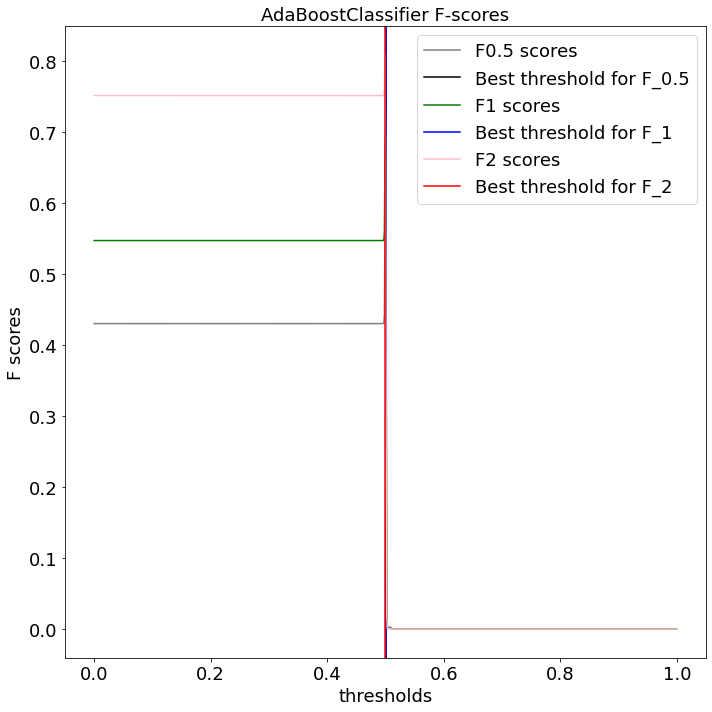

<ipython-input-29-dac20e61f652>:2: RuntimeWarning: invalid value encountered in true_divide
  return (1+beta**2)*(pre*rec)/((beta**2)*pre + rec)


Best Threshold for F_0.5: 0.500128, F_0.5-Score=0.727
Best Threshold for F_1: 0.499627, F_1-Score=0.720
Best Threshold for F_2: 0.499010, F_2-Score=0.808


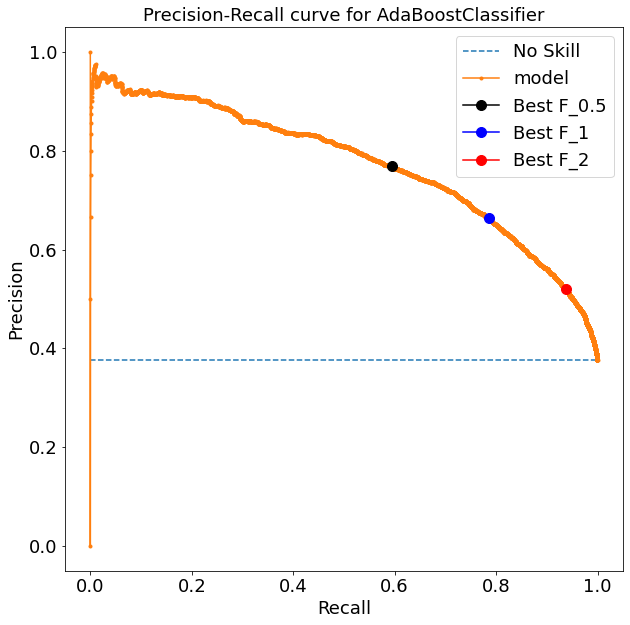

Best Threshold=0.499657, G-Mean=0.773


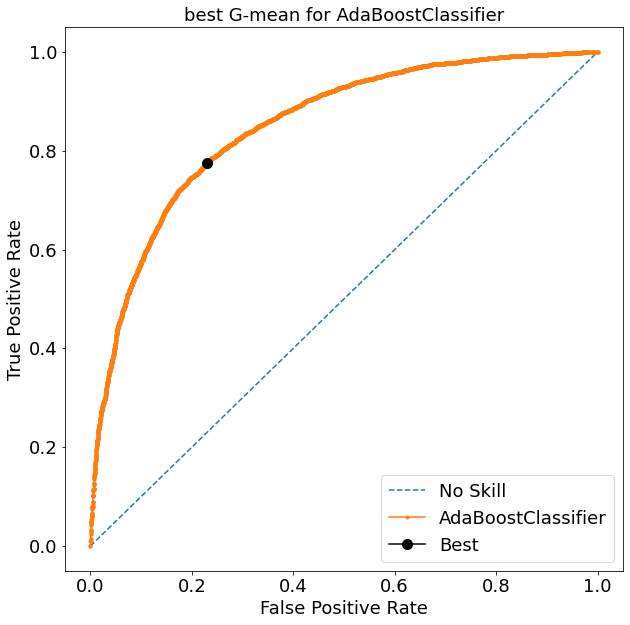

ROC AUC score:  0.850099674239635
Threshold for  F_0.5 :  0.5001279605870247
Confusion matrix: 
 [[5523  664]
 [1514 2220]]
Classification report:
               precision    recall  f1-score   support

       False       0.78      0.89      0.84      6187
        True       0.77      0.59      0.67      3734

    accuracy                           0.78      9921
   macro avg       0.78      0.74      0.75      9921
weighted avg       0.78      0.78      0.77      9921

Threshold for  F_1 :  0.49962679220304007
Confusion matrix: 
 [[4709 1478]
 [ 802 2932]]
Classification report:
               precision    recall  f1-score   support

       False       0.85      0.76      0.81      6187
        True       0.66      0.79      0.72      3734

    accuracy                           0.77      9921
   macro avg       0.76      0.77      0.76      9921
weighted avg       0.78      0.77      0.77      9921

Threshold for  F_2 :  0.4990103623777254
Confusion matrix: 
 [[2963 3224]
 [ 232 3502

In [35]:
for clf in list(models.values()):
    results(clf)

## Feature Importance

In [76]:
fi = pd.DataFrame({'features':X.columns,'feature_importance':models['GBC'].feature_importances_})\
    .set_index('features')\
    .sort_values('feature_importance',ascending=False)

In [77]:
fi

,feature_importance
features,
avg_rating_by_driver,0.300819
city_King's Landing,0.147431
surge_pct,0.124996
weekday_pct,0.110551
ultimate_black_user,0.058933
avg_dist,0.052972
trips_in_first_30_days,0.051602
phone_iPhone,0.041597
phone_Android,0.037282


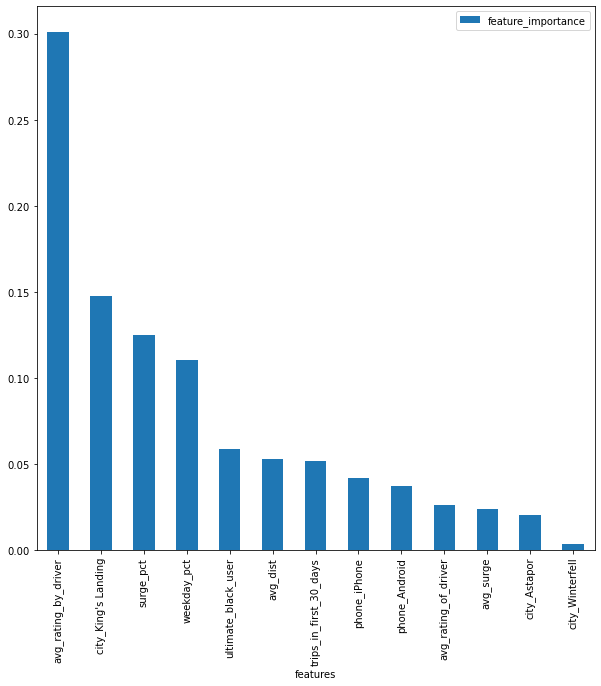

In [78]:
fi.plot(kind='bar')
plt.show()

In [49]:
def vif_analysis(data):
    
    cols = list(data.columns)

    for i in range(len(cols)):
        cols[i] = cols[i].replace(" ", '_')
        cols[i] = cols[i].replace("'", '_')

    data.columns = cols

    
    #gather features
    features = "+".join(data.columns[1:])

    # get y and X dataframes based on this regression:
    y_vif, X_vif = dmatrices('target' + ' ~' + features, data, return_type='dataframe')
    X_vif = add_constant(X_vif)

    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    vif["features"] = X_vif.columns

    print('Largest VIF Factor: ', vif.round(1).sort_values('VIF Factor', ascending=False).head(1))

    y_log = data['target']
    X_log = add_constant(data.drop('target',axis=1))

    y_train = y_log[mask]
    X_train = X_log[mask]

    logit_model = Logit(y_train,np.asarray(X_train))
    logit_result = logit_model.fit(maxiter=40)
    summary = logit_result.summary()
    results_as_html = summary.tables[1].as_html()
    logit_res = pd.read_html(scaled_results_as_html, header=0, index_col=0)[0]

    # numeric
    print('Coefficients: ', logit_scaled_res.sort_values('coef', ascending=False))
          
         
#     X_log = add_constant(data.drop(target,axis=1))
#     X_train, X_test, y_train, y_test = train_test_split(X_log,y_log, stratify=y_log, random_state=2)
#     logit_model = Logit(y_train,X_train)
#     logit_result = logit_model.fit(maxiter=40)
#     summary = logit_result.summary()
#     results_as_html = summary.tables[1].as_html()
#     logit_res = pd.read_html(results_as_html, header=0, index_col=0)[0]
#     print('Coefficients for unscaled data: ', logit_res.head(20))  
          
    return logit_res



In [50]:
fi = vif_analysis(df)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Largest VIF Factor:       VIF Factor      features
224         inf  phone_iPhone


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).